In [2]:
!ls

drive  sample_data


In [3]:
%cd drive/MyDrive/Hackathon/HackUTD/

/content/drive/MyDrive/Hackathon/HackUTD


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import joblib
from datetime import datetime, timedelta

class HydrateDetectionSystem:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )

    def preprocess_data(self, df):
        """Preprocess the data and engineer features."""
        # Convert time to datetime
        df['Time'] = pd.to_datetime(df['Time'])

        # Fill missing values
        df = df.fillna(method='ffill')

        # Create features
        df['hour'] = df['Time'].dt.hour
        df['valve_change'] = df['Inj Gas Valve Percent Open'].diff()
        df['volume_diff'] = df['Inj Gas Meter Volume Instantaneous'] - df['Inj Gas Meter Volume Setpoint']
        df['volume_change'] = df['Inj Gas Meter Volume Instantaneous'].diff()

        # Calculate rolling statistics
        df['volume_rolling_mean'] = df['Inj Gas Meter Volume Instantaneous'].rolling(window=6).mean()
        df['volume_rolling_std'] = df['Inj Gas Meter Volume Instantaneous'].rolling(window=6).std()

        # Create hydrate formation label (detect sudden drops in volume and valve compensation)
        df['hydrate_forming'] = ((df['volume_change'] < -20) &
                               (df['Inj Gas Valve Percent Open'].diff() > 5)).astype(int)

        # Create features for prediction (looking at previous timepoints)
        for i in [1, 2, 3]:
            df[f'volume_lag_{i}'] = df['Inj Gas Meter Volume Instantaneous'].shift(i)
            df[f'valve_lag_{i}'] = df['Inj Gas Valve Percent Open'].shift(i)

        # Drop rows with NaN values after feature engineering
        df = df.dropna()

        return df

    def prepare_features(self, df):
        """Prepare feature matrix X and target vector y."""
        feature_columns = [
            'hour', 'Inj Gas Valve Percent Open', 'volume_diff',
            'volume_rolling_mean', 'volume_rolling_std', 'valve_change',
            'volume_lag_1', 'volume_lag_2', 'volume_lag_3',
            'valve_lag_1', 'valve_lag_2', 'valve_lag_3'
        ]

        X = df[feature_columns]
        y = df['hydrate_forming']

        return X, y

    def train(self, training_files):
        """Train the model using multiple CSV files."""
        combined_data = []

        for file in training_files:
            df = pd.read_csv(file)
            processed_df = self.preprocess_data(df)
            combined_data.append(processed_df)

        full_dataset = pd.concat(combined_data, ignore_index=True)
        X, y = self.prepare_features(full_dataset)

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Train model
        self.model.fit(X_scaled, y)

    def predict_risk(self, current_data):
        """Predict hydrate formation risk for new data."""
        processed_data = self.preprocess_data(current_data)
        X, _ = self.prepare_features(processed_data)
        X_scaled = self.scaler.transform(X)

        # Get probability of hydrate formation
        risk_probabilities = self.model.predict_proba(X_scaled)[:, 1]

        # Add predictions to dataframe
        processed_data['hydrate_risk'] = risk_probabilities

        # Generate alerts for high-risk situations (risk > 70%)
        alerts = processed_data[processed_data['hydrate_risk'] > 0.7]

        return processed_data['hydrate_risk'].iloc[-1], alerts

    def save_model(self, path):
        """Save the trained model and scaler."""
        model_data = {
            'model': self.model,
            'scaler': self.scaler
        }
        joblib.dump(model_data, path)

    def load_model(self, path):
        """Load a trained model and scaler."""
        model_data = joblib.load(path)
        self.model = model_data['model']
        self.scaler = model_data['scaler']

# Helper function to simulate real-time data stream
def simulate_data_stream(csv_file, chunk_size=10):
    """Simulate real-time data streaming from CSV file."""
    df = pd.read_csv(csv_file)
    for i in range(0, len(df), chunk_size):
        yield df.iloc[i:i+chunk_size]

In [5]:
detector = HydrateDetectionSystem()
training_files = ['./data/Bold_744H-10_31-11_07.csv', './data/Courageous_729H-09_25-09_28.csv']
detector.train(training_files)
detector.save_model('hydrate_detector.joblib')

<ipython-input-1-fd35e4d21ba9>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])
<ipython-input-1-fd35e4d21ba9>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
<ipython-input-1-fd35e4d21ba9>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])
<ipython-input-1-fd35e4d21ba9>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


<ipython-input-1-fd35e4d21ba9>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])
<ipython-input-1-fd35e4d21ba9>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
<ipython-input-1-fd35e4d21ba9>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])
<ipython-input-1-fd35e4d21ba9>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
<ipython-input-1-fd35e4d21ba9>:23: UserWarning: Could not infer format


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1716
           1       1.00      0.67      0.80         3

    accuracy                           1.00      1719
   macro avg       1.00      0.83      0.90      1719
weighted avg       1.00      1.00      1.00      1719



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Hackathon/HackUTD/evaluation_results/confusion_matrix.png'

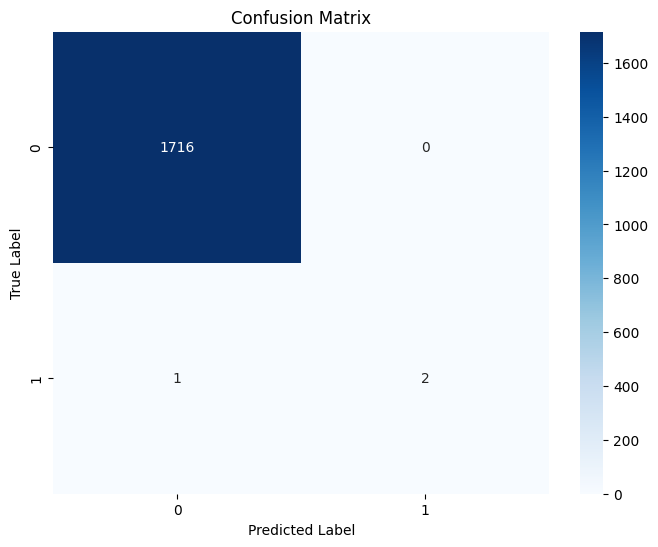

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import shap

class HydrateModelEvaluator:
    def __init__(self, detection_system):
        self.detection_system = detection_system

    def evaluate_model(self, test_file, output_path=None):
        """Comprehensive model evaluation"""
        # Load and preprocess test data
        test_df = pd.read_csv(test_file)
        processed_df = self.detection_system.preprocess_data(test_df)
        X, y = self.detection_system.prepare_features(processed_df)
        X_scaled = self.detection_system.scaler.transform(X)

        # Get predictions
        y_pred = self.detection_system.model.predict(X_scaled)
        y_pred_proba = self.detection_system.model.predict_proba(X_scaled)[:, 1]

        # 1. Basic Classification Metrics
        print("\n=== Classification Report ===")
        print(classification_report(y, y_pred))

        # 2. Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        if output_path:
            plt.savefig(f'{output_path}/confusion_matrix.png')
        plt.close()

        # 3. ROC Curve
        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        if output_path:
            plt.savefig(f'{output_path}/roc_curve.png')
        plt.close()

        # 4. Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y, y_pred_proba)
        pr_auc = auc(recall, precision)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        if output_path:
            plt.savefig(f'{output_path}/pr_curve.png')
        plt.close()

        # 5. Feature Importance
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.detection_system.model.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='importance', y='feature')
        plt.title('Feature Importance')
        plt.xlabel('Importance Score')
        if output_path:
            plt.savefig(f'{output_path}/feature_importance.png')
        plt.close()

        # 6. Time Series Cross-Validation
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = cross_val_score(
            self.detection_system.model,
            X_scaled,
            y,
            cv=tscv,
            scoring='roc_auc'
        )

        print("\n=== Time Series Cross-Validation Scores ===")
        print(f"Mean ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

        # 7. SHAP Values for Model Interpretability
        explainer = shap.TreeExplainer(self.detection_system.model)
        shap_values = explainer.shap_values(X_scaled)

        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance')
        if output_path:
            plt.savefig(f'{output_path}/shap_importance.png')
        plt.close()

        return {
            'classification_report': classification_report(y, y_pred, output_dict=True),
            'confusion_matrix': cm,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'cv_scores': cv_scores,
            'feature_importance': feature_importance
        }

    def analyze_misclassifications(self, test_file):
        """Analyze cases where the model made incorrect predictions"""
        # Load and preprocess test data
        test_df = pd.read_csv(test_file)
        processed_df = self.detection_system.preprocess_data(test_df)
        X, y = self.detection_system.prepare_features(processed_df)
        X_scaled = self.detection_system.scaler.transform(X)

        # Get predictions
        y_pred = self.detection_system.model.predict(X_scaled)

        # Identify misclassified samples
        misclassified = processed_df[y != y_pred].copy()
        misclassified['predicted'] = y_pred[y != y_pred]
        misclassified['actual'] = y[y != y_pred]

        # Analyze characteristics of false positives and false negatives
        false_positives = misclassified[misclassified['predicted'] == 1]
        false_negatives = misclassified[misclassified['predicted'] == 0]

        print("\n=== Misclassification Analysis ===")
        print(f"Total misclassifications: {len(misclassified)}")
        print(f"False positives: {len(false_positives)}")
        print(f"False negatives: {len(false_negatives)}")

        # Calculate statistics for misclassified cases
        stats = {
            'false_positives': {
                'avg_volume': false_positives['Inj Gas Meter Volume Instantaneous'].mean(),
                'avg_valve': false_positives['Inj Gas Valve Percent Open'].mean(),
                'common_hours': false_positives['hour'].mode().values
            },
            'false_negatives': {
                'avg_volume': false_negatives['Inj Gas Meter Volume Instantaneous'].mean(),
                'avg_valve': false_negatives['Inj Gas Valve Percent Open'].mean(),
                'common_hours': false_negatives['hour'].mode().values
            }
        }

        print("\nFalse Positive Characteristics:")
        print(f"Average Volume: {stats['false_positives']['avg_volume']:.2f}")
        print(f"Average Valve Opening: {stats['false_positives']['avg_valve']:.2f}%")
        print(f"Most Common Hours: {stats['false_positives']['common_hours']}")

        print("\nFalse Negative Characteristics:")
        print(f"Average Volume: {stats['false_negatives']['avg_volume']:.2f}")
        print(f"Average Valve Opening: {stats['false_negatives']['avg_valve']:.2f}%")
        print(f"Most Common Hours: {stats['false_negatives']['common_hours']}")

        return misclassified, stats

# Example usage:
if __name__ == "__main__":
    # Initialize the detection system
    detector = HydrateDetectionSystem()

    # Train the model
    training_files = [
        './data/Bold_744H-10_31-11_07.csv',
        './data/Courageous_729H-09_25-09_28.csv',
        './data/Fearless_709H-10_31-11_07.csv',
        './data/Gallant_102H-10_04-10_11.csv',
        './data/Noble_4H-10_24-10_29.csv',
        './data/Resolute_728H-10_14-10_21.csv',
        './data/Ruthless_745H-10_01-10_08.csv'
    ]  # Add more training files
    detector.train(training_files)

    # Initialize evaluator
    evaluator = HydrateModelEvaluator(detector)

    # Evaluate the model
    test_file = './data/Valiant_505H-09_22-09_30.csv'  # Use a different file for testing
    results = evaluator.evaluate_model(test_file, output_path='evaluation_results')

    # Analyze misclassifications
    misclassified, stats = evaluator.analyze_misclassifications(test_file)